# Big Mart Sales III

### The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

### Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

 

### Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

 

Variable

Description

Item_Identifier

Unique product ID

Item_Weight

Weight of product

Item_Fat_Content

Whether the product is low fat or not

Item_Visibility

The % of total display area of all products in a store allocated to the particular product

Item_Type

The category to which the product belongs

Item_MRP

Maximum Retail Price (list price) of the product

Outlet_Identifier

Unique store ID

Outlet_Establishment_Year

The year in which store was established

Outlet_Size

The size of the store in terms of ground area covered

Outlet_Location_Type

The type of city in which the store is located

Outlet_Type

Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales

Sales of the product in the particulat store. This is the outcome variable to be predicted.

 

### import packages

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [164]:
train  = pd.read_csv('Train.csv')
test  = pd.read_csv('Test.csv')
submission  = pd.read_csv('SampleSubmission.csv')

In [165]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [166]:
# Copy of original data
train_original=train.copy()
test_original=test.copy()

In [167]:
train.columns, test.columns

(Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type', 'Item_Outlet_Sales'],
       dtype='object'),
 Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type'],
       dtype='object'))

In [168]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [169]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

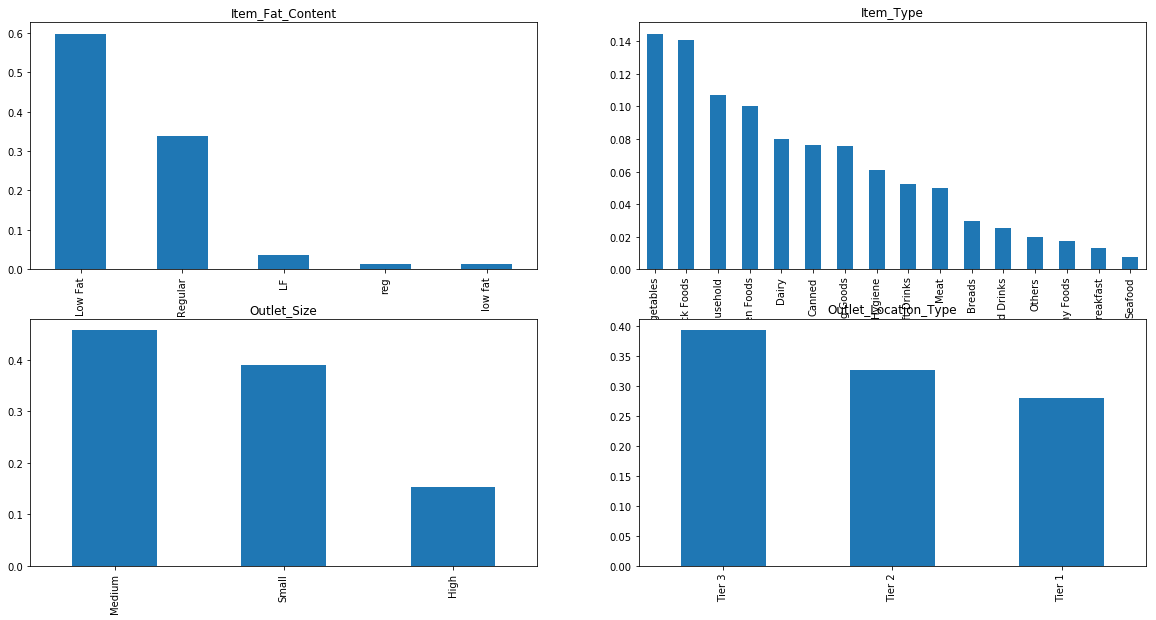

In [170]:
# Visualizing categorical features
plt.figure(1)
plt.subplot(221)
train['Item_Fat_Content'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Item_Fat_Content')

plt.subplot(222)
train['Item_Type'].value_counts(normalize=True).plot.bar(title= 'Item_Type')

plt.subplot(223)
train['Outlet_Size'].value_counts(normalize=True).plot.bar(title= 'Outlet_Size')

plt.subplot(224)
train['Outlet_Location_Type'].value_counts(normalize=True).plot.bar(title= 'Outlet_Location_Type')

plt.show()

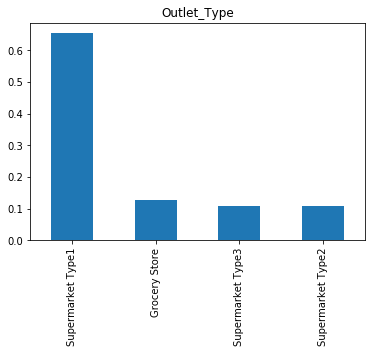

In [171]:
train['Outlet_Type'].value_counts(normalize=True).plot.bar(title= 'Outlet_Type')

In [172]:
#age convertion
import datetime
now = datetime.datetime.now()
now.year

train["Outlet_Age"] = now.year - train["Outlet_Establishment_Year"]
train["Outlet_Age"].head()

0    19
1     9
2    19
3    20
4    31
Name: Outlet_Age, dtype: int64

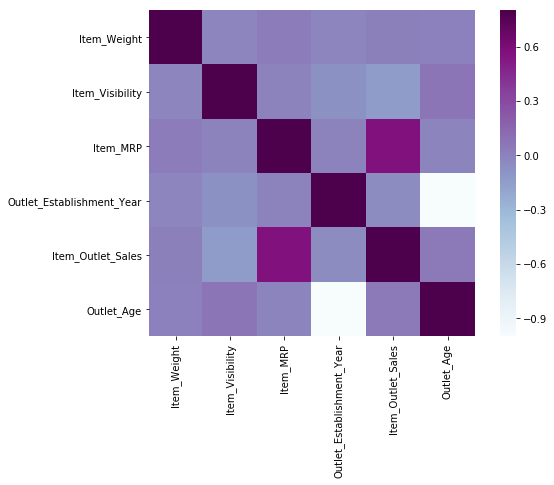

In [173]:
# Print correlation matrix
matrix = train.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [174]:
Item_Identifier = train['Item_Identifier']
y = train['Item_Outlet_Sales']
X = train.drop('Item_Outlet_Sales',1)
X = X.drop('Item_Identifier',1)

In [175]:
### To impute "Outlet_Size for OUT010", we will build a classifier

### Changing the categorical data to numeric/dummy

##### imputing ordinal data

mapping_Item_Type = {'Fruits and Vegetables': "Fruit_Veg",
                    'Household':"HH_HH", 'Health and Hygiene':"HH_HH",
                    'Baking Goods': "Bake_Snacks", 'Snack Foods': "Bake_Snacks",
                    'Canned': "Frozen_Canned", 'Frozen Foods': "Frozen_Canned",
                    'Dairy': "DBBS", 'Breakfast': "DBBS", 'Breads': "DBBS", 'Starchy Foods': "DBBS",
                    'Seafood':"Seafood_Meat", 'Meat': "Seafood_Meat",
                    'Hard Drinks': "Drinks", 'Soft Drinks': "Drinks",
                    'Others':"Others"}
train['Item_Type'] = train['Item_Type'].map(mapping_Item_Type)

mapping_Item_Fat_Content = {'Regular': 1, "reg": 1,'LF': 0,'Low Fat': 0, "low fat":0}
train['Item_Fat_Content'] = train['Item_Fat_Content'].map(mapping_Item_Fat_Content)

mapping_Outlet_Size = {'Small': 1, "Medium": 2,'High': 3}
train['Outlet_Size'] = train['Outlet_Size'].map(mapping_Outlet_Size)

In [176]:
# Adding dummies to the dataset
X=pd.get_dummies(X)

In [177]:
#X['Item_Identifier']=Item_Identifier
X.shape

(8523, 46)

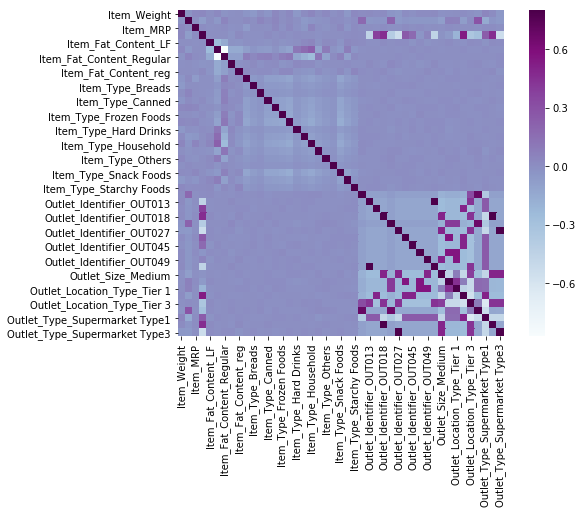

In [39]:
# Print correlation matrix
matrix = X.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [162]:
X.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [46]:
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""

'from sklearn.preprocessing import StandardScaler\nsc_X = StandardScaler()\nX_train = sc_X.fit_transform(X_train)\nX_test = sc_X.transform(X_test)\nsc_y = StandardScaler()\ny_train = sc_y.fit_transform(y_train)'

In [26]:
X['Item_Weight'].fillna(X['Item_Weight'].mode()[0], inplace=True)

In [41]:
X.isnull().sum()

Item_Weight                        0
Item_Visibility                    0
Item_MRP                           0
Outlet_Establishment_Year          0
Item_Fat_Content_LF                0
Item_Fat_Content_Low Fat           0
Item_Fat_Content_Regular           0
Item_Fat_Content_low fat           0
Item_Fat_Content_reg               0
Item_Type_Baking Goods             0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
Outlet_Identifier_OUT010           0
Outlet_Identifier_OUT013           0
O

In [155]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
regressor = RandomForestRegressor(n_estimators = 3, random_state = 0)
regressor.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [156]:
# Predicting a new result
y_pred = regressor.predict(X)

In [83]:
len(y_pred)

8523

In [84]:
print(r2_score(y, y_pred))

0.8569000013718373


In [100]:
from sklearn import linear_model
regressor = linear_model.LinearRegression(fit_intercept=True,normalize=True)
regressor.fit (X,y)
y_pred = regressor.predict(X)
print(r2_score(y, y_pred))

0.5638365587865677


In [101]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 10,max_depth=3)
regressor.fit(X, y)
y_pred = regressor.predict(X)
print(r2_score(y, y_pred))

0.5249445020797421


In [102]:
from sklearn.ensemble import AdaBoostRegressor
regressor = AdaBoostRegressor(n_estimators=100,loss="linear",learning_rate=.005)
regressor.fit(X, y)
yy_predicted = regressor.predict(X)
#print(metrics.mean_squared_error(y_true=yy_test, y_pred=yy_predicted))
print(r2_score(y, y_pred))

0.5249445020797421


In [104]:
Ridge = linear_model.Ridge(random_state=10,normalize=True,alpha=.001)
Ridge

Ridge.fit(X,y)
#print(Ridge.intercept_)
#coef1 = pd.DataFrame(Ridge.coef_,XCols,columns=["Value"])
#coef1[coef1["Value"]>0].sort_values(by="Value",ascending=False)

yy_predicted = Ridge.predict(X)
#print(metrics.mean_squared_error(y_true=yy_test, y_pred=yy_predicted))
print(r2_score(y, y_pred))

0.5249445020797421


## Training is completed after evaluating the all models RandomForest is some what better

In [141]:
test.shape

(5681, 11)

In [142]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [143]:
submission =  test.loc[:,["Item_Identifier","Outlet_Identifier","Item_MRP"]]
#submission.head()

In [144]:
#age convertion
import datetime
now = datetime.datetime.now()
now.year

test["Outlet_Age"] = now.year - test["Outlet_Establishment_Year"]
#test["Outlet_Age"].head()


In [145]:
test = test.drop('Outlet_Establishment_Year',1)

In [146]:
### To impute "Outlet_Size for OUT010", we will build a classifier

### Changing the categorical data to numeric/dummy

##### imputing ordinal data

mapping_Item_Type = {'Fruits and Vegetables': "Fruit_Veg",
                    'Household':"HH_HH", 'Health and Hygiene':"HH_HH",
                    'Baking Goods': "Bake_Snacks", 'Snack Foods': "Bake_Snacks",
                    'Canned': "Frozen_Canned", 'Frozen Foods': "Frozen_Canned",
                    'Dairy': "DBBS", 'Breakfast': "DBBS", 'Breads': "DBBS", 'Starchy Foods': "DBBS",
                    'Seafood':"Seafood_Meat", 'Meat': "Seafood_Meat",
                    'Hard Drinks': "Drinks", 'Soft Drinks': "Drinks",
                    'Others':"Others"}
test['Item_Type'] = test['Item_Type'].map(mapping_Item_Type)

mapping_Item_Fat_Content = {'Regular': 1, "reg": 1,'LF': 0,'Low Fat': 0, "low fat":0}
test['Item_Fat_Content'] = test['Item_Fat_Content'].map(mapping_Item_Fat_Content)

mapping_Outlet_Size = {'Small': 1, "Medium": 2,'High': 3}
test['Outlet_Size'] = test['Outlet_Size'].map(mapping_Outlet_Size)

In [147]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,FDW58,20.750,0,0.007565,Bake_Snacks,107.8622,OUT049,2.0,Tier 1,Supermarket Type1,19
1,FDW14,8.300,1,0.038428,DBBS,87.3198,OUT017,NaN,Tier 2,Supermarket Type1,11
2,NCN55,14.600,0,0.099575,Others,241.7538,OUT010,NaN,Tier 3,Grocery Store,20
3,FDQ58,7.315,0,0.015388,Bake_Snacks,155.0340,OUT017,NaN,Tier 2,Supermarket Type1,11
4,FDY38,NaN,1,0.118599,DBBS,234.2300,OUT027,2.0,Tier 3,Supermarket Type3,33


In [150]:
test.isnull().sum()

Item_Identifier         0
Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Outlet_Age              0
dtype: int64

In [149]:
test['Item_Weight'].fillna(test['Item_Weight'].mode()[0], inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)

In [152]:
Item_Identifier = test['Item_Identifier']

test = test.drop('Item_Identifier',1)

In [181]:
test=pd.get_dummies(test)

In [154]:
test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Age,Item_Type_Bake_Snacks,Item_Type_DBBS,Item_Type_Drinks,Item_Type_Frozen_Canned,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,20.750,0,0.007565,107.8622,2.0,19,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,8.300,1,0.038428,87.3198,2.0,11,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,14.600,0,0.099575,241.7538,2.0,20,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,7.315,0,0.015388,155.0340,2.0,11,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,10.500,1,0.118599,234.2300,2.0,33,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [157]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
regressor = RandomForestRegressor(n_estimators = 3, random_state = 0)
regressor.fit(X, y)
# Predicting a new result
y_pred = regressor.predict(test)
#print(r2_score(y, y_pred))

ValueError: Number of features of the model must match the input. Model n_features is 45 and input n_features is 31 

In [179]:
X.columns

(Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year', 'Outlet_Age', 'Item_Fat_Content_LF',
        'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
        'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
        'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
        'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
        'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
        'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
        'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
        'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
        'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
        'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
        'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
        'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
        'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT0

(5681, 1588)